# Interferometric Imaging: Phase & Amplitude Errors

This notebook shows a few examples of the effects of *phase* and *amplitude* calibration errors.

These are errors that, in practice, affect single *antennae* in an array.

That in turn means that these errors affect many baselines.

In [29]:
from astropy import units as u
import numpy as np
%matplotlib inline
import pylab as pl
from astropy.visualization import simple_norm
from astropy.modeling.models import Gaussian2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

pl.style.use('dark_background')
pl.rcParams['figure.figsize'] = (12,12)
pl.rcParams['font.size'] = 16
pl.rcParams['image.cmap'] = 'inferno'

In [30]:
imshape = [64,64]
yy,xx = np.indices(imshape)
xx = xx-imshape[1]/2
yy = yy-imshape[0]/2
rr = ((xx)**2 + (yy)**2)**0.5
rrint = rr.astype('int')

img = Gaussian2D(x_stddev=0.5,y_stddev=2,theta=25*u.deg)(xx,yy)
noise = np.random.randn(*img.shape) * 0.01
img += noise
ftim = np.fft.fftshift(np.fft.fft2(img))

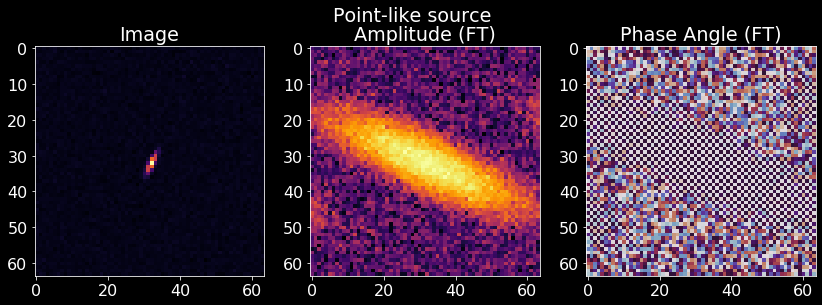

In [83]:
pl.figure(figsize=(14,4.5))
pl.subplot(1,3,1).imshow(img)
pl.title("Image")
pl.suptitle("Point-like source")
_=pl.subplot(1,3,2).imshow(np.abs(ftim),
                           norm=simple_norm(np.abs(ftim), stretch='asinh'))
pl.title("Amplitude (FT)")
_=pl.subplot(1,3,3).imshow(np.angle(ftim).value, cmap=pl.cm.twilight)
_=pl.title("Phase Angle (FT)")

In [56]:
def show_im_and_ft(ft_sample, title="Filled outer apertures (long-baseline only)", normim=img,
                   sampling=None, stretch='asinh'
                  ):
    fig = pl.figure(figsize=(14,4.5))
    ax1 = pl.subplot(1,3,1)
    im = ax1.imshow(np.abs(np.fft.ifft2(ft_sample)),
                    norm=simple_norm(normim, stretch=stretch))
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, ax=ax1)
    ax1.set_title('Image')
    _=pl.suptitle(title)
    pl.subplot(1,3,2).imshow(np.abs(ft_sample),
                               norm=simple_norm(np.abs(ftim), stretch='log', min_percent=1))
    pl.title("FT amp.")
    if sampling is None:
        _=pl.subplot(1,3,3).imshow(np.angle(ft_sample), vmin=-np.pi, vmax=np.pi, cmap=pl.cm.twilight_shifted)
        pl.title("FT phase")
    else:
        psf = np.abs(np.fft.fftshift(np.fft.ifft2(sampling)))
        _=pl.subplot(1,3,3).imshow(psf)
        pl.title("PSF")

    pl.subplots_adjust(wspace=0.35)

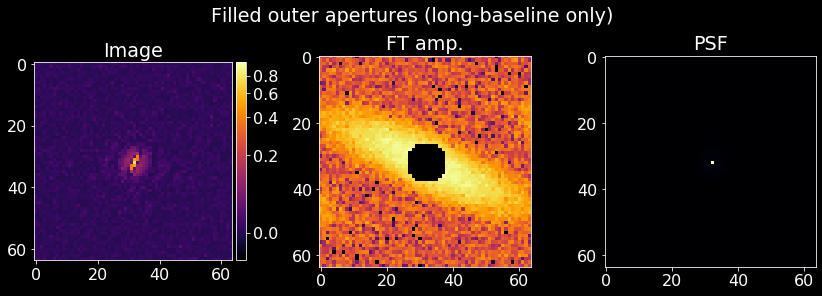

In [57]:
ft_sample = np.zeros_like(ftim)

ft_sample[rrint > 5] = ftim[rrint > 5]

show_im_and_ft(ft_sample, sampling=rrint > 5)

In [58]:
# introduce phase error
phase = np.angle(ftim)
amp = np.abs(ftim)

bad_phase = phase.copy()
bad_phase[32:64,32:64] += np.pi/2 * u.rad

ftim_degraded = amp * np.exp(1j * bad_phase.to(u.rad).value)

# Phase errors are asymmetric

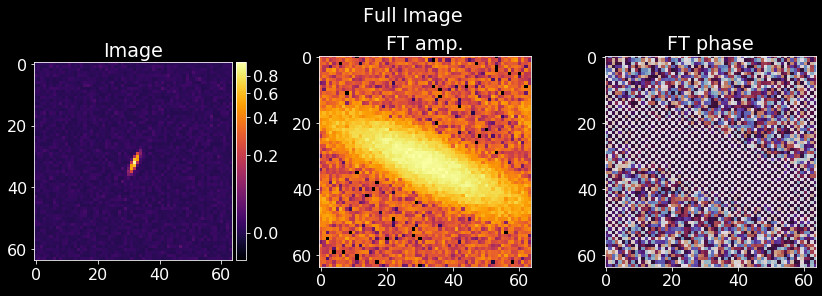

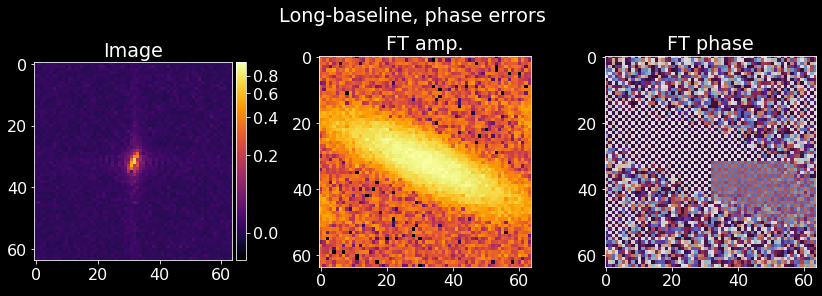

In [59]:
show_im_and_ft(ftim, title="Full Image")
show_im_and_ft(ftim_degraded, title="Long-baseline, phase errors")

In [60]:
# introduce amplitude error
phase = np.angle(ftim)
amp = np.abs(ftim)

bad_amp = amp.copy()
bad_amp[32:64,32:64] *= 2

ftim_degraded = bad_amp * np.exp(1j * phase.to(u.rad).value)

# Amplitude errors are symmetric

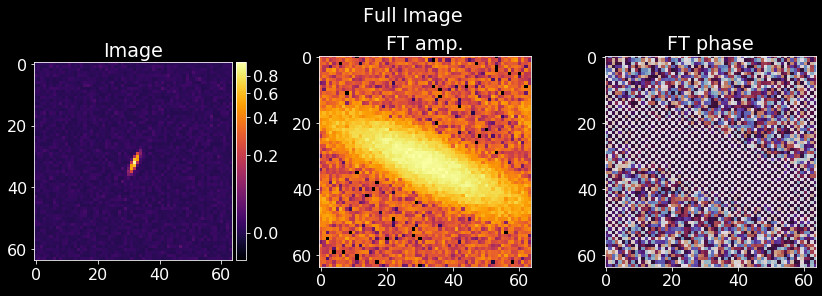

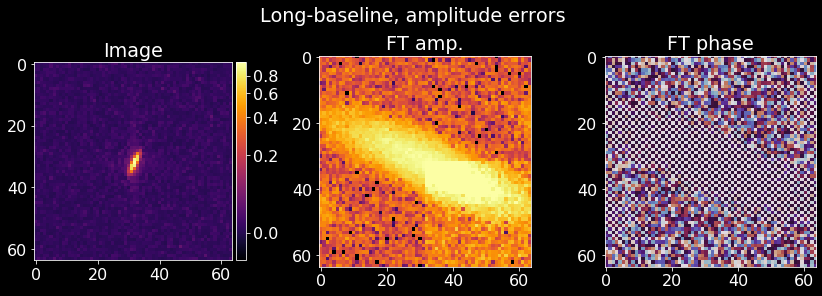

In [61]:
show_im_and_ft(ftim, title="Full Image")
show_im_and_ft(ftim_degraded, title="Long-baseline, amplitude errors")

# Make a synthetic VLA-like array

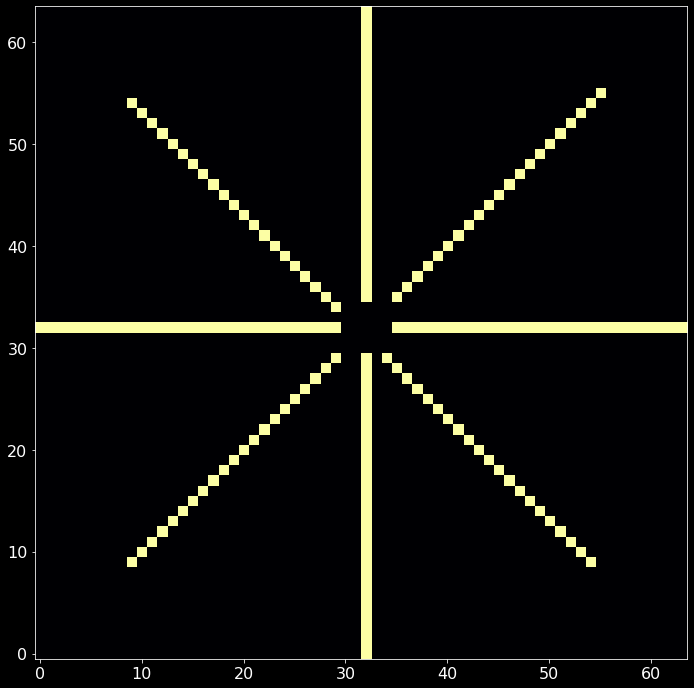

In [62]:
sampling = np.zeros(img.shape, dtype='bool')
sampling[32,:] = True
sampling[:,32] = True
diagy,diagx = np.diag_indices_from(sampling)
sampling[diagy,diagx] = True
sampling[diagy[::-1], diagx] = True
#sampling[diagy[:32], diagx[:32]] = True
#sampling[diagy[31::-1], diagx[32:]] = True
sampling[30:35,30:35] = False
sampling[rrint>32] = False
pl.imshow(sampling, origin='lower')

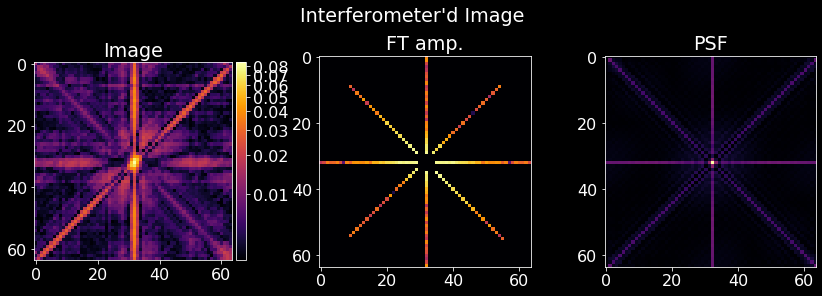

In [63]:
ftsample = ftim * sampling
sampled_img = np.abs(np.fft.ifft2(ftsample))
show_im_and_ft(ftsample, title="Interferometer'd Image", normim=sampled_img, sampling=sampling)

In [64]:
# again, introduce phase error
phase = np.angle(ftsample)
amp = np.abs(ftsample)

bad_phase = phase.copy()
bad_phase[32:64,32:64] += np.pi/2 * u.rad

ftsample_degraded = amp * np.exp(1j * bad_phase.to(u.rad).value)

# Phase errors in realistically-sampled array

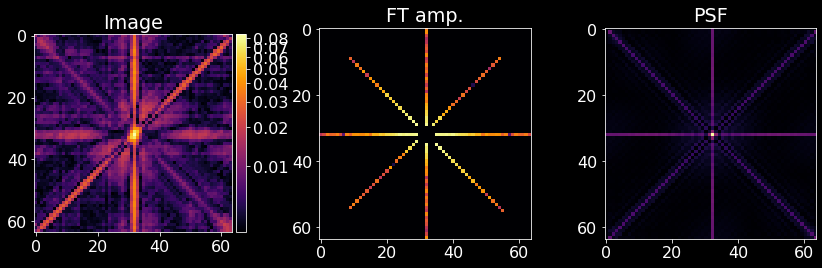

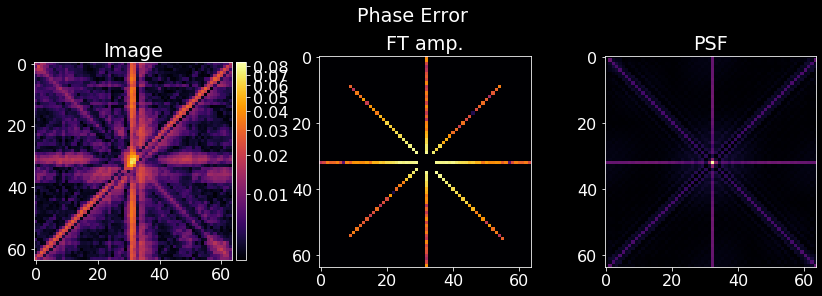

In [65]:
show_im_and_ft(ftsample, title="", normim=sampled_img, sampling=sampling)
show_im_and_ft(ftsample_degraded, title="Phase Error", normim=sampled_img, sampling=sampling)

In [66]:
# introduce amplitude error again
phase = np.angle(ftsample)
amp = np.abs(ftsample)

bad_amp = amp.copy()
bad_amp[32:64,32:64] *= 2

ftsample_degraded = bad_amp * np.exp(1j * phase.to(u.rad).value)

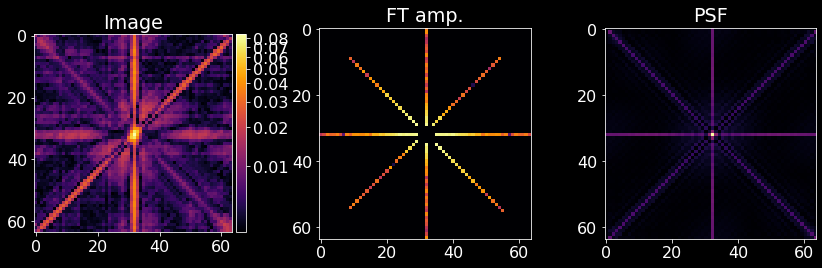

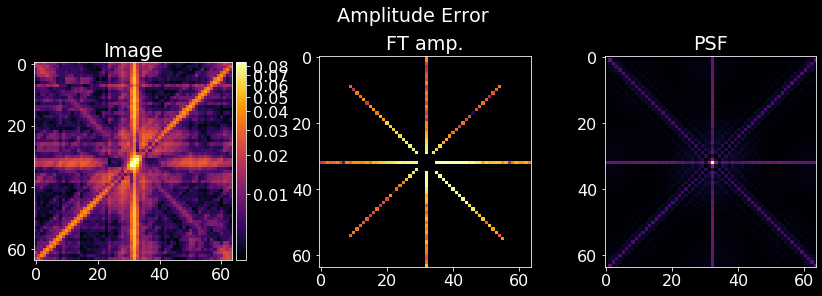

In [67]:
show_im_and_ft(ftsample, title="", normim=sampled_img, sampling=sampling)
show_im_and_ft(ftsample_degraded, title="Amplitude Error", normim=sampled_img, sampling=sampling)

# Make a synthetic, more realistic array

In [68]:
def plot_ants_baselines(antennae, baselines):
    fig = pl.figure(figsize=(12,6))
    ax1 = pl.subplot(1,2,1)
    ax1.plot(*antenna_positions.T, 'o')
    ax1.set_xlabel("X distance")
    ax1.set_ylabel("Y distance")
    ax1.set_title("Antenna Positions")
    ax2 = pl.subplot(1,2,2)
    ax2.set_title("Baselines")
    ax2.set_xlabel('U')
    ax2.set_ylabel('V')
    ax2.plot(*baselines.T, 'o')

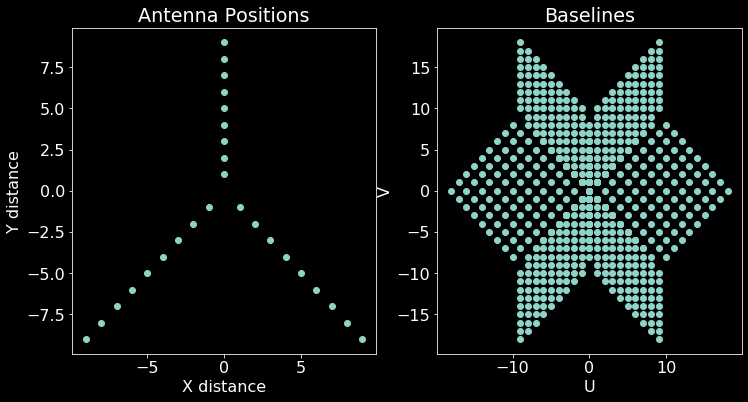

In [69]:
# three "arms": north, southwest, southeast
antenna_positions = np.array(
    [(0,y) for y in range(1,10)] +
    [(-x,-y) for x,y in zip(range(1,10),range(1,10))] + 
    [(x,-y) for x,y in zip(range(1,10),range(1,10))], dtype='float')
baselines = (antenna_positions[None,:,:] - antenna_positions[:,None,:]).reshape(27**2, 2)
plot_ants_baselines(antenna_positions, baselines)

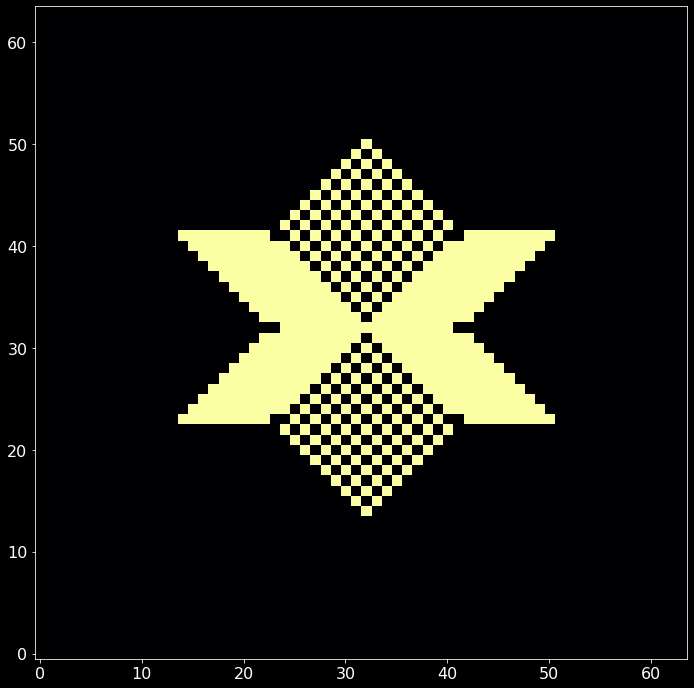

In [70]:
sampling = np.zeros(img.shape, dtype='bool')
sampling[baselines.astype('int')[:,0]+32, baselines.astype('int')[:,1]+32] = True
pl.imshow(sampling, origin='lower')

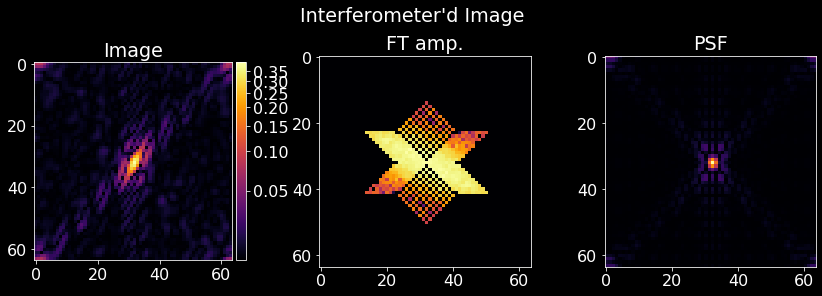

In [71]:
ftsample = ftim * sampling
sampled_img = np.abs(np.fft.ifft2(ftsample))
show_im_and_ft(ftsample, title="Interferometer'd Image", normim=sampled_img, sampling=sampling)

## What if one antenna has bad phase or amplitude?

In [72]:
baselines = (antenna_positions[None,:,:] - antenna_positions[:,None,:])
badant = 4
bad_antenna_baselines = np.concatenate([baselines[badant,:,:], baselines[:,badant,:]])
baselines = baselines.reshape(baselines.shape[0]*baselines.shape[1], baselines.shape[2])

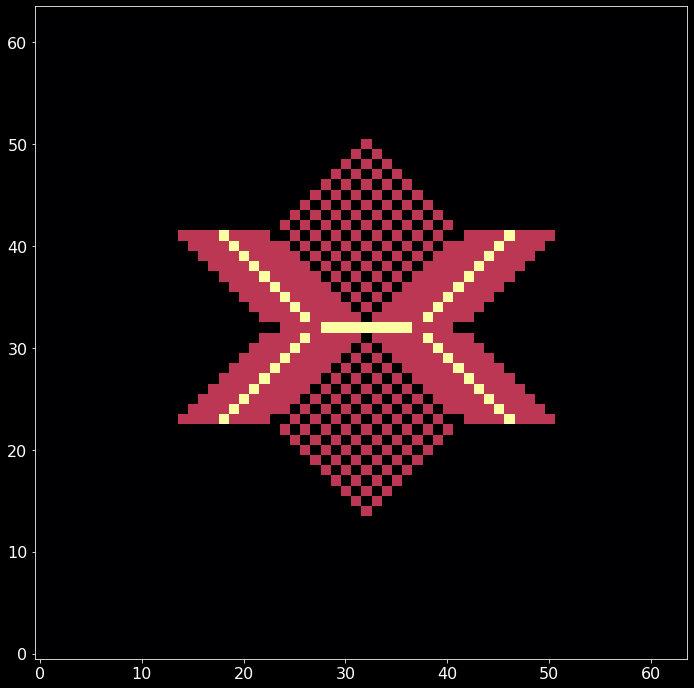

In [73]:
sampling = np.zeros(img.shape, dtype='bool')
sampling[baselines.astype('int')[:,0]+32, baselines.astype('int')[:,1]+32] = True
sampling_bad = np.zeros(img.shape, dtype='bool')
sampling_bad[bad_antenna_baselines.astype('int')[:,0]+32, 
             bad_antenna_baselines.astype('int')[:,1]+32] = True
sampling[sampling_bad] = False
pl.imshow(sampling + 2*sampling_bad, origin='lower')

# Bad phase example

For the bad antenna, along all baselines, a phase offset is added

In [76]:
ftsample = ftim * (sampling + sampling_bad)
phase = np.angle(ftsample)
amp = np.abs(ftsample)

bad_phase = phase.copy()
bad_phase[sampling_bad] += np.pi/2 * u.rad

ftsample_degraded = amp * np.exp(1j * bad_phase.to(u.rad).value)

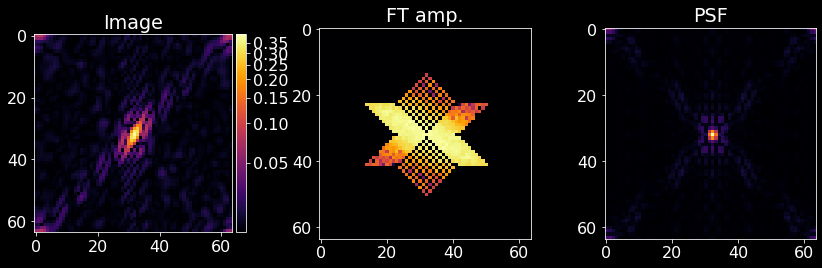

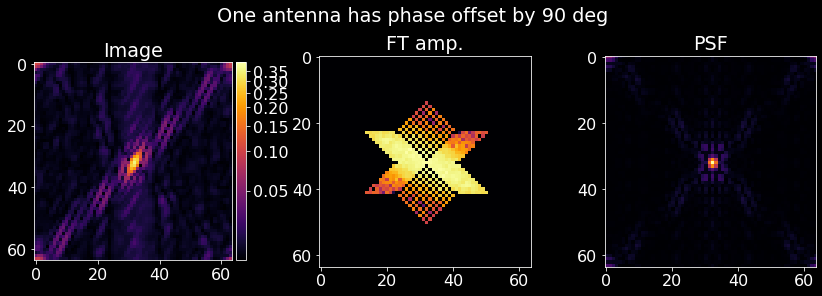

In [77]:
show_im_and_ft(ftsample, title="", normim=sampled_img, sampling=sampling)
show_im_and_ft(ftsample_degraded, title="One antenna has phase offset by 90 deg", normim=sampled_img, sampling=sampling)

# Bad Phase Part 2

The bad antenna, along all baselines, sees a different source

(this type of error is generally uncorrectable, as it involves a non-antenna-based correction)

In [78]:
ftsample = ftim * (sampling + sampling_bad)
phase = np.angle(ftsample)
amp = np.abs(ftsample)

bad_phase = phase.copy()
bad_phase[sampling_bad] = np.angle(
    np.fft.fftshift(np.fft.fft2(
        np.roll(np.roll(img, -16, axis=1),
                0, axis=0))))[sampling_bad]


ftsample_degraded = amp * np.exp(1j * bad_phase.to(u.rad).value)

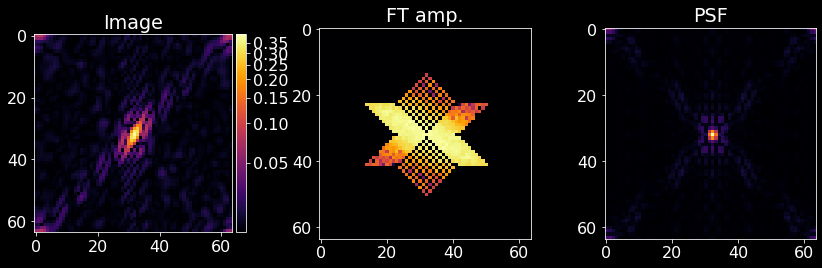

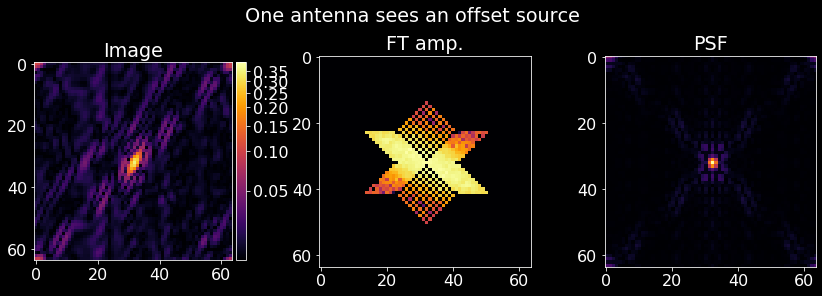

In [79]:
show_im_and_ft(ftsample, title="", normim=sampled_img, sampling=sampling)
show_im_and_ft(ftsample_degraded, title="One antenna sees an offset source", normim=sampled_img, sampling=sampling)

# Bad amplitude on one antenna



In [80]:
ftsample = ftim * (sampling + sampling_bad)
phase = np.angle(ftsample)
amp = np.abs(ftsample)

bad_amp = amp.copy()
bad_amp[sampling_bad] = 0

ftsample_degraded = bad_amp * np.exp(1j * phase.to(u.rad).value)

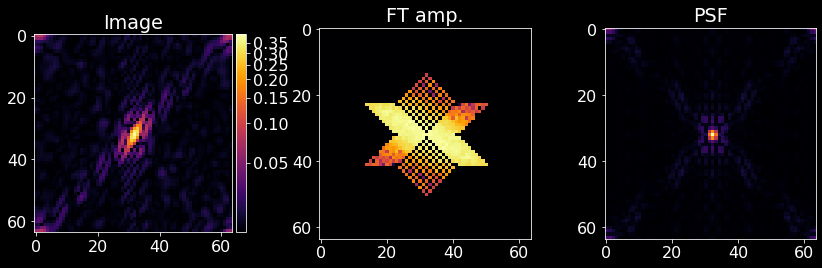

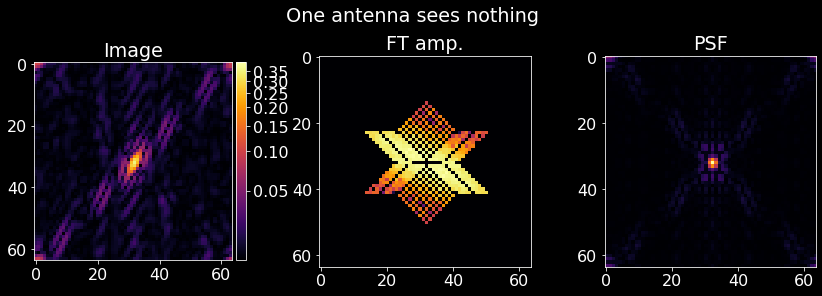

In [81]:
show_im_and_ft(ftsample, title="", normim=sampled_img, sampling=sampling)
show_im_and_ft(ftsample_degraded, title="One antenna sees nothing", normim=sampled_img, sampling=sampling)

Done